In [15]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim, flatten
from torch.nn import Linear, Conv2d, MaxPool2d, BatchNorm2d, Module, Dropout, ReLU
import torch.nn.functional as F
torch.manual_seed(0)
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Simulated Function

In [2]:
x = torch.linspace(-1,1,200)
x=x[:,None]
y = np.sin(5 * 3.142 * x)/(5 * 3.142 * x)
print(x.shape)

torch.Size([200, 1])


In [3]:
class Network1(nn.Module):
    def __init__(self):
        super(Network1, self).__init__()
        self.fc1 = nn.Linear(1,170)
        self.fc2 = nn.Linear(170,200)
        self.fc3 = nn.Linear(200,1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)        
        return x

In [33]:
model = Network1()
loss_fn = torch.nn.MSELoss()
epochs =10000
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
errorloss =[]
grad_list = []


for i in range(epochs):
    optimizer.zero_grad()
    output = model.forward(x)
    loss = loss_fn(output, y)
    #output_1.append(output.detach().numpy())
    loss=loss.float()
    loss.backward()
    optimizer.step()
    errorloss.append(loss.item())
    #if i % 2000 == 0:
    #print(f'Epoch {i}/{epochs}....Training Loss {loss.item():.8f}')
    
    #Calculate Gradient Norm
    grad_all = 0.0
    for p in model.parameters():
        grad =0
        if p.grad is not None:
            grad = (p.grad.cpu().data.numpy() ** 2).sum()
        grad_all+=grad
    grad_norm = grad_all**0.5
    grad_list.append(grad_norm)  
print(f'Epoch {i}/{epochs}....Training Loss {loss.item():.8f}')


Epoch 9999/10000....Training Loss 0.00317352


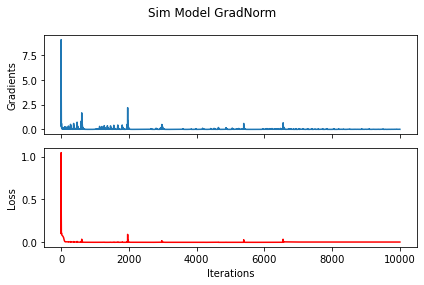

In [34]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.suptitle('Sim Model GradNorm')
ax1.plot(np.arange(epochs), grad_list)
ax2.plot(np.arange(epochs), errorloss, 'r')
plt.xlabel('Iterations')
ax1.set_ylabel('Gradients')
ax2.set_ylabel('Loss')
fig.tight_layout()
plt.show();

# GRADIENT NORM FOR MNIST DATA 

In [12]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,)),
                               ])

trainset = datasets.MNIST('./', download=True, train=True,  transform=transform)
testset = datasets.MNIST('./', download=True, train=False, transform=transform)
print(trainset.data.size())

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True)
#print(len(trainloader))

torch.Size([60000, 28, 28])


In [13]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = Conv2d(1,16, kernel_size=3,stride=1,padding=1)
        self.pool = MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = Conv2d(16,32, kernel_size=3,stride=1,padding=1)
        self.fc1 = nn.Linear(32*7*7,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x) 
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        
        #x = F.log_softmax(self.fc3(x), dim=1)       
        return x

In [26]:
model = CNN()
model.to(device)
optimize = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.NLLLoss()
step = 0
epoch = 30
trainloss = []
grad_listM = []
for e in range(epoch):
    train_loss = 0
    train_acc = 0
    for images, labels in trainloader:
        step+=1
        images, labels = images.to(device), labels.to(device)
        model.zero_grad()
        logps = model(images) #forward propagation
        loss = loss_fn(logps, labels) #calculate loss
        train_loss+=loss.item() 
        loss.backward() #backward propagation
        optimize.step() #update weights
        trainloss.append(loss.item())
    
        #Calculate Gradient Norm
        grad_all = 0.0
        for p in model.parameters():
            grad =0
            if p.grad is not None:
                grad = (p.grad.cpu().data.numpy() ** 2).sum()
            grad_all+=grad
        grad_norm = grad_all**0.5
        grad_listM.append(grad_norm)  
        
    if e%2==0:
        print("Epoch: {}  Train Loss: {:.4f}".format(e, train_loss/len(trainloader)))

Epoch: 0  Train Loss: 0.2528
Epoch: 2  Train Loss: 0.0400
Epoch: 4  Train Loss: 0.0227
Epoch: 6  Train Loss: 0.0153
Epoch: 8  Train Loss: 0.0100
Epoch: 10  Train Loss: 0.0082
Epoch: 12  Train Loss: 0.0078
Epoch: 14  Train Loss: 0.0053
Epoch: 16  Train Loss: 0.0062
Epoch: 18  Train Loss: 0.0034
Epoch: 20  Train Loss: 0.0042
Epoch: 22  Train Loss: 0.0020
Epoch: 24  Train Loss: 0.0048
Epoch: 26  Train Loss: 0.0044
Epoch: 28  Train Loss: 0.0022


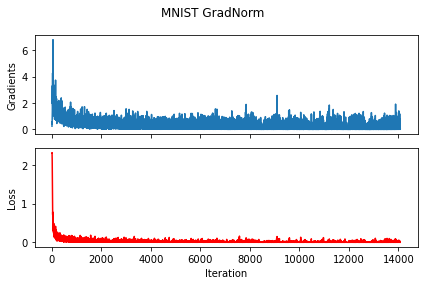

In [30]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.suptitle('MNIST GradNorm')
ax1.plot(np.arange(step), grad_listM)
ax2.plot(np.arange(step), trainloss, 'r')
plt.xlabel('Iteration')
ax1.set_ylabel('Gradients')
ax2.set_ylabel('Loss')
fig.tight_layout()
plt.show();